# 3. Emotion and iCAPS composition

In [1]:
from src import *

## Table of Contents
- [Emotion item data](#emotion)
    - Reformatting
    - Exploring

## Description

Extract the ground truth emotions: 3FA and compare counts statistics

Per Subject
- Try to relate 3FA to counts

Across Subjects
- Again relate the probability series to 3FA 
- Linear combination of transient states activated (regressors being binary or simply the weights to reconstruct 3FA)

GOAL: Delineate (if any) relation between valence / arousal / power and presence of given icaps (positive / negative / combinations)

### Extract the stats from timecourses and the 3FA

In [2]:
filmnames = list(FILM2DURATION.keys())
fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float)

In [328]:
root = '/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/'
ids = [file for file in os.listdir(root) if 'sub' in file]

clust_roots = ['iCAPs_results/iCAPS_Emo_Movies_{}_Alpha_5_95_Fraction_0DOT05/'.format(_id) for _id in ids]
ncaps = 20
# SHIFT = int(WASH + ONSET)
SHIFT = int(WASH)

In [4]:
timecourse_char = []
labels = []
for idx in [1,4]:
    labels.append(ids[idx])
    timecourse_char.append(loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT4.mat')['tempChar'][0][0])
    
timecourse_char = np.stack(timecourse_char)

In [152]:
sidx = 0
properties = timecourse_char[sidx]

# Basic values of iCAPS timecourses
tc_norm_thes = properties[4][0]
tc_active = properties[5][0]
nb_coactive_time = properties[6][0]

# How many times a icaps appear during the movie (as a percentage)
ratio_active_icaps = properties[13]
ratio_pactive_icaps = properties[14]
ratio_nactive_icaps = properties[15]

# coupling counts
coupling_count = properties[22]
coupling_countratio = properties[23] # divided by either icaps being activated
diffsign_coupling_count = properties[29]
samesign_coupling_count = properties[28]

# index 24-27 useless and index 30-34 are for jaccard index if needed

In [153]:
filmsnames = np.array(list(FILM2DURATION.keys()))

fmri_trs = []
for k in range(len(nb_coactive_time)):
    L = nb_coactive_time[k].shape[1]
    fmri_trs.append(L)

invert = {v:u for (u,v) in ANNOT_TR_FILM.items()} 
ordered_movies = [invert[fmri_trs[k]] for k in range(len(fmri_trs))]
ordered_movies = ordered_movies[1:]

In [209]:
metric1 = np.nan_to_num(tc_norm_thes[1:]) # remove Rest
metric2 = np.nan_to_num(tc_active[1:]) # remove Rest
metric3 = np.nan_to_num(nb_coactive_time[1:])

In [225]:
# Select in the run only TRs that have equivalent in 3FA evaluations
tmp = []
tmp2 = []
tmp3 = []

for k in range(len(metric1)):
    tmp.append(metric1[k][:,SHIFT:SHIFT + fa_timecourse[ordered_movies[k]].shape[0]])
    tmp2.append(metric2[k][:,SHIFT:SHIFT + fa_timecourse[ordered_movies[k]].shape[0]])
    tmp3.append(metric3[k][:,SHIFT:SHIFT + fa_timecourse[ordered_movies[k]].shape[0]][0])
    
# Compute timecourse metric concatenated
icaps_timecourses = []
icaps_timecourses_count = []
nb_icaps_timecourses = np.concatenate(tmp3)

for s in range(ncaps):
    icaps_timecourses.append(np.concatenate([tmp[k][s] for k in range(len(tmp))]))
    icaps_timecourses_count.append(np.concatenate([tmp2[k][s] for k in range(len(tmp2))]))
    
icaps_timecourses = np.asarray(icaps_timecourses)
icaps_timecourses_count = np.asarray(icaps_timecourses_count)
n = icaps_timecourses[0].shape[-1]

In [172]:
# Compute 3FAs concatenated
fa3 = []
for k in range(3):
    fa3.append(np.concatenate([fa_timecourse[film][:,k] for film in ordered_movies]))
    
fa3 = np.asarray(fa3)

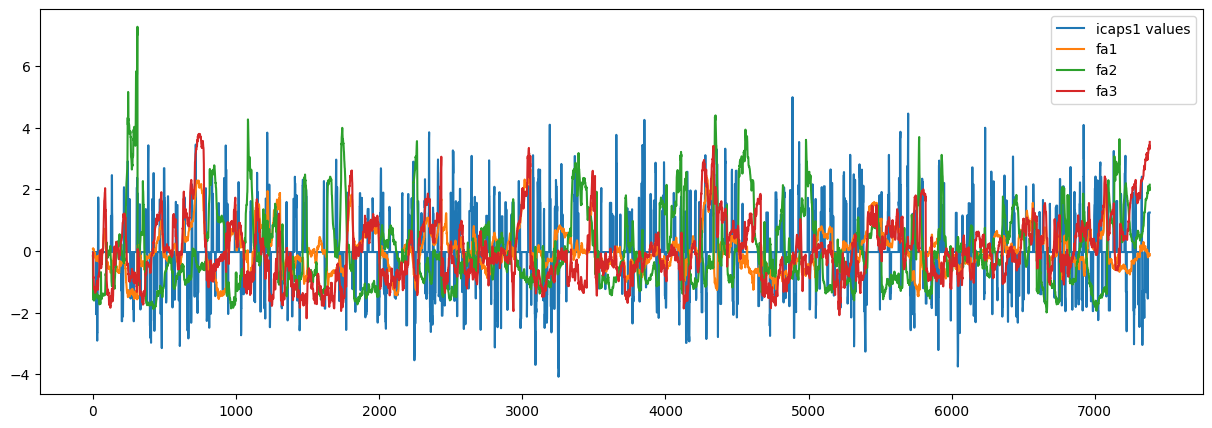

In [74]:
plt.figure(figsize=(15,5))
plt.plot(zscore(icaps_timecourses[0]), label='icaps1 values')
plt.plot(zscore(fa3)[0], label='fa1')
plt.plot(zscore(fa3)[1], label='fa2')
plt.plot(zscore(fa3)[2], label='fa3')
plt.legend()

### GLM Approach to know 'meaningful' combination of icaps

In [203]:
def glm_stats_3fa(regressors,fa3):
    """
    Compute the t-stats and p-values GLM
    """
    glmnet = {}
    beta_fit = {}
    labels = ['valence', 'arousal','power']

    for i in range(3):
        # Computing to fit series
        y = fa3[i]
        y = zscore(y)

        # regress solving
        X = regressors.T

        beta = (np.linalg.inv(np.matmul(X.T, X)) @ X.T) @ y

        y_hat_meter = X @ beta

        N = y.size
        P = X.shape[1]
        df = (N - P)

        sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
        design_variance_weight = design_variance(X, 1)
        # print("Degrees of freedom: %i" % df)
        # print("Sigma-hat (noise) is: %.3f" % sigma_hat)

        # t-stats
        t_meter = beta / np.sqrt(sigma_hat * design_variance_weight)

        # multiply by two to create a two-tailed p-value
        p_values = np.array([stats.t.sf(np.abs(t), df) * 2  for t in t_meter])

        glmnet[labels[i]] = (t_meter,p_values)
        beta_fit[labels[i]] = beta

    return glmnet, beta_fit

In [204]:
# REGRESSORS to compute beta values from

# Scores Activations and activations counts
regressors = [np.ones(n)]
regressors = np.asarray(regressors + icaps_timecourses)

regressors_count = [np.ones(n)]
regressors_count = np.asarray(regressors_count + icaps_timecourses_count)

In [206]:
glmnet, beta_fit = glm_stats_3fa(regressors[:,:3000], fa3[:,:3000])
glmnet_retest, _ = glm_stats_3fa(regressors[:,3000:], fa3[:,3000:])

glmnet_count, beta_fit_count = glm_stats_3fa(regressors_count, fa3)

print('cutoff: {}'.format(stats.t.sf(1.963, 7364) * 2))
# print('cutoff: {}'.format(stats.t.sf(1.963, 2979) * 2))

cutoff: 0.049683758160356487


In [199]:
from matplotlib import cm
def inplotbar(dct, tdf=1.963):
    # GLOBALS used
    colors = cm.rainbow(np.linspace(0, 1, ncaps))

    fig, ax = plt.subplots(3,1,figsize=(10,10))
    df = {'icaps': np.arange(1,21), 't-stats': dct['valence'][0][1:]}
    sns.barplot(data=df, x="icaps", y="t-stats", ax=ax[0])
    ax[0].axhline(y=tdf, color='r', linestyle='--',label='pval=0.05')
    ax[0].axhline(y=-tdf, color='k', linestyle='--',label='pval=0.05')
    ax[0].legend()

    df = {'icaps': np.arange(1,21), 't-stats': dct['arousal'][0][1:]}
    sns.barplot(data=df, x="icaps", y="t-stats", ax=ax[1])
    ax[1].axhline(y=tdf, color='r', linestyle='--',label='pval=0.05')
    ax[1].axhline(y=-tdf, color='k', linestyle='--',label='pval=0.05')
    ax[1].legend()
    
    df = {'icaps': np.arange(1,21), 't-stats': dct['power'][0][1:]}
    sns.barplot(data=df, x="icaps", y="t-stats", ax=ax[2])
    ax[2].axhline(y=tdf, color='r', linestyle='--',label='pval=0.05')
    ax[2].axhline(y=-tdf, color='k', linestyle='--',label='pval=0.05')
    ax[2].legend()
    
    ax[0].set_ylabel('t-test')
    ax[0].set_xlabel('icaps')
    plt.show()

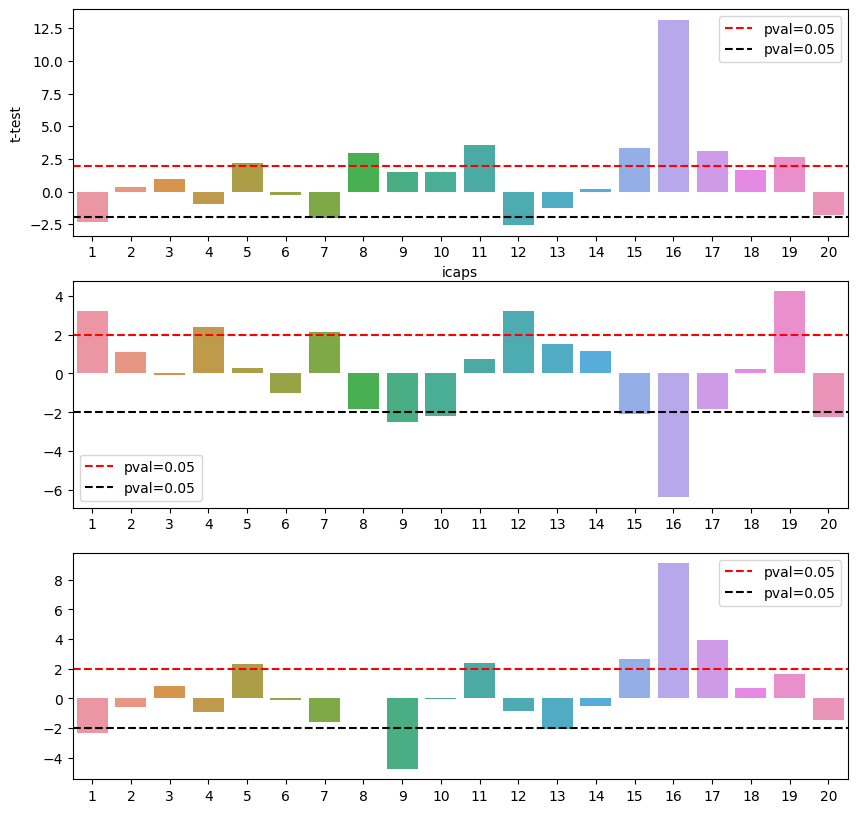

In [200]:
inplotbar(glmnet)

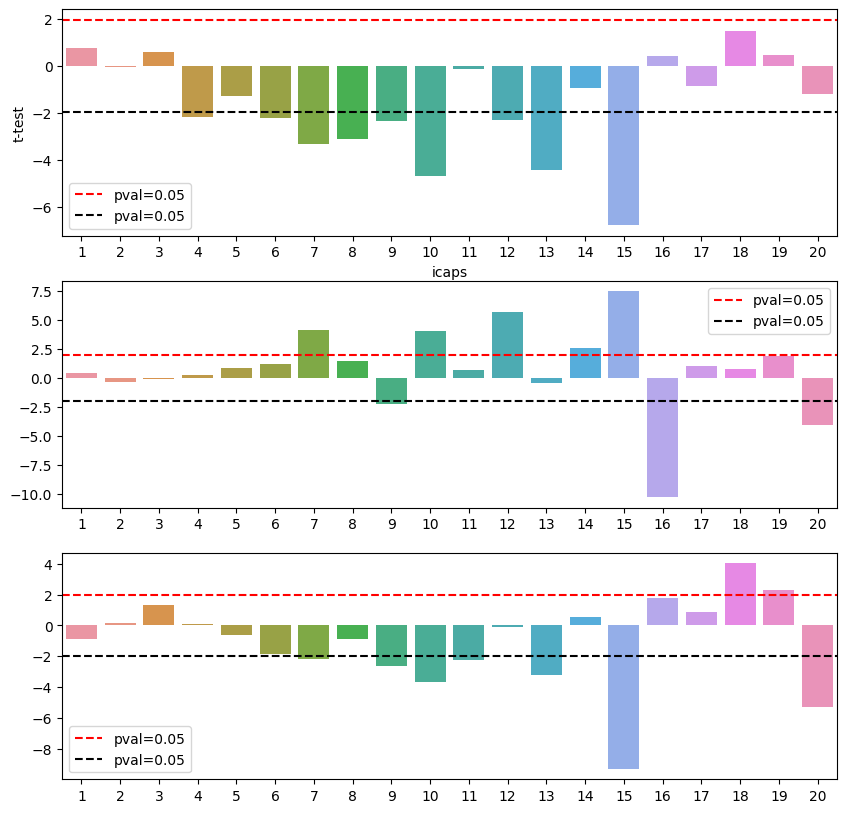

In [201]:
inplotbar(glmnet_retest)

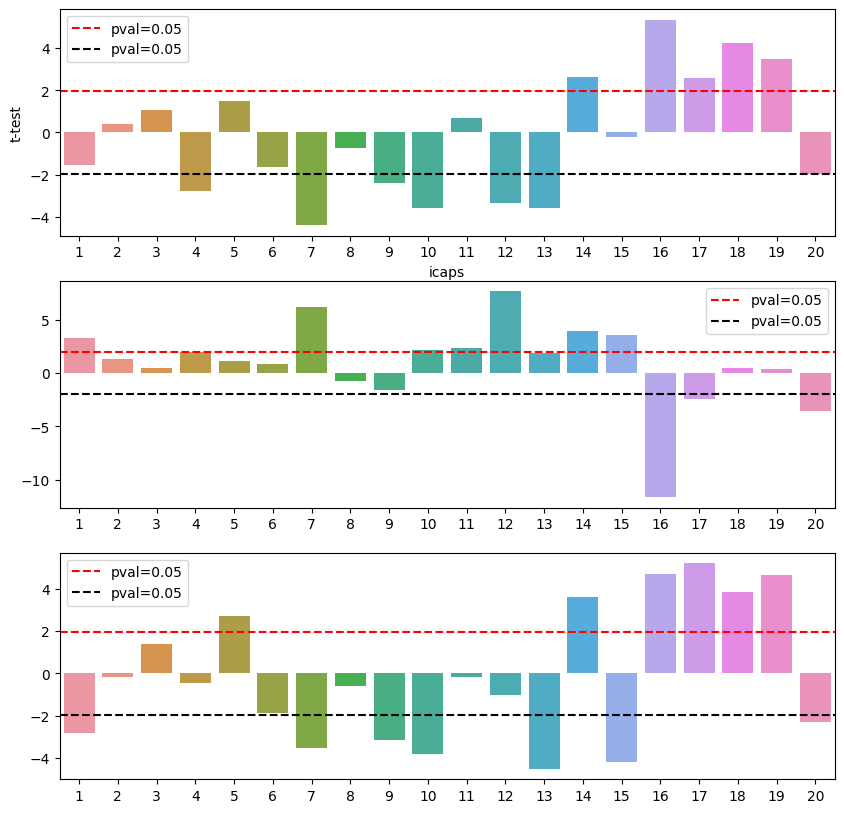

In [202]:
inplotbar(glmnet_count)

### Change of states? do we see a combination changes of states when sharp transition of valence/arousal/power happens?

Compute states changes in terms of iCAPS combinations
- (Hammer distance with binary switch)

In [316]:
def compute_states_dynamism(states, metric='hammer'):
    """ 
    Compute the change of states over time
    
    Input: states (NxT) N being the dimension of the state and T being the number of timepoints
    Return: scalar quantifiying changes over time
    """
    
    diff_states = states[:,1:] - states[:,:-1]
    if metric == 'hammer':
        ret = np.abs(diff_states).sum(axis=0)

    elif metric == 'euclidean':
        ret = np.sqrt((diff_states**2).sum(axis=0))
    
    return ret

In [326]:
rest_states = np.abs(tc_active[0])
movie_states = np.abs(icaps_timecourses_count)

rest_dynstate = compute_states_dynamism(rest_states)
movie_dynstate = compute_states_dynamism(movie_states)

<Axes: >

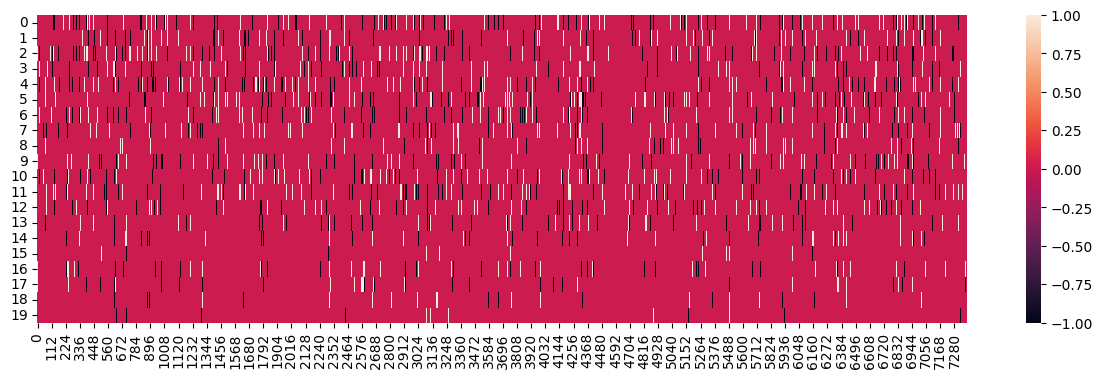

In [314]:
plt.figure(figsize=(15,4))
sns.heatmap(movie_states[:,1:] - movie_states[:,:-1])

<Axes: >

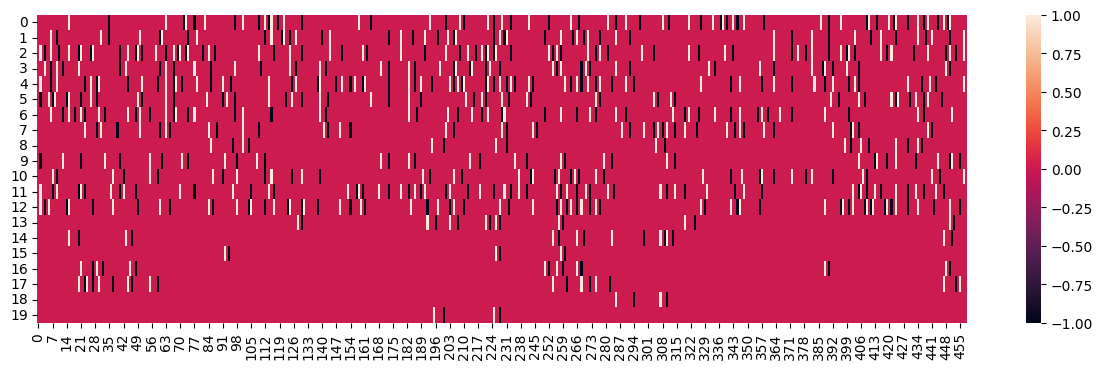

In [315]:
plt.figure(figsize=(15,4))
sns.heatmap(rest_states[:,1:] - rest_states[:,:-1])

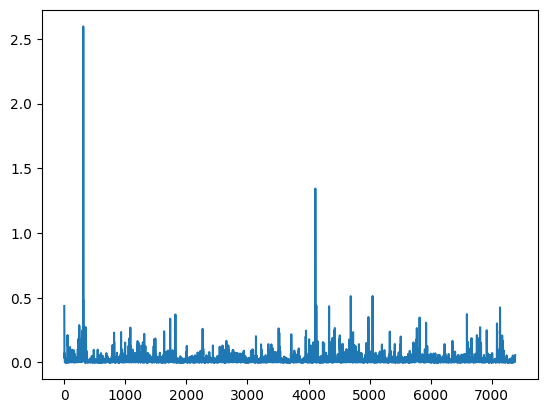

In [271]:
plt.plot(np.abs(np.diff(fa3[1])))

In [327]:
ordered_movies

['Chatter',
 'Spaceman',
 'BigBuckBunny',
 'LessonLearned',
 'YouAgain',
 'BetweenViewing',
 'TearsOfSteel',
 'TheSecretNumber',
 'Sintel',
 'AfterTheRain',
 'FirstBite',
 'ToClaireFromSonny',
 'Payload',
 'Superhero']

### Analysis of 3FA with high score iCAPS metrics (inverse approach to GLM)

- at high icaps count as a correlation?

- at high synchronization as a correlation?

In [258]:
high_nbicaps = np.percentile(nb_icaps_timecourses, 95)
low_nbicaps = np.percentile(nb_icaps_timecourses, 5)
t1,t2 = np.percentile(nb_icaps_timecourses, 45), np.percentile(nb_icaps_timecourses, 55)

highthresh_fa3 = fa3[:,nb_icaps_timecourses >= high_nbicaps]
lowthresh_fa3 = fa3[:,nb_icaps_timecourses <= low_nbicaps]
midthresh_fa3 = fa3[:,(nb_icaps_timecourses >= t1) &  (nb_icaps_timecourses <= t2)]

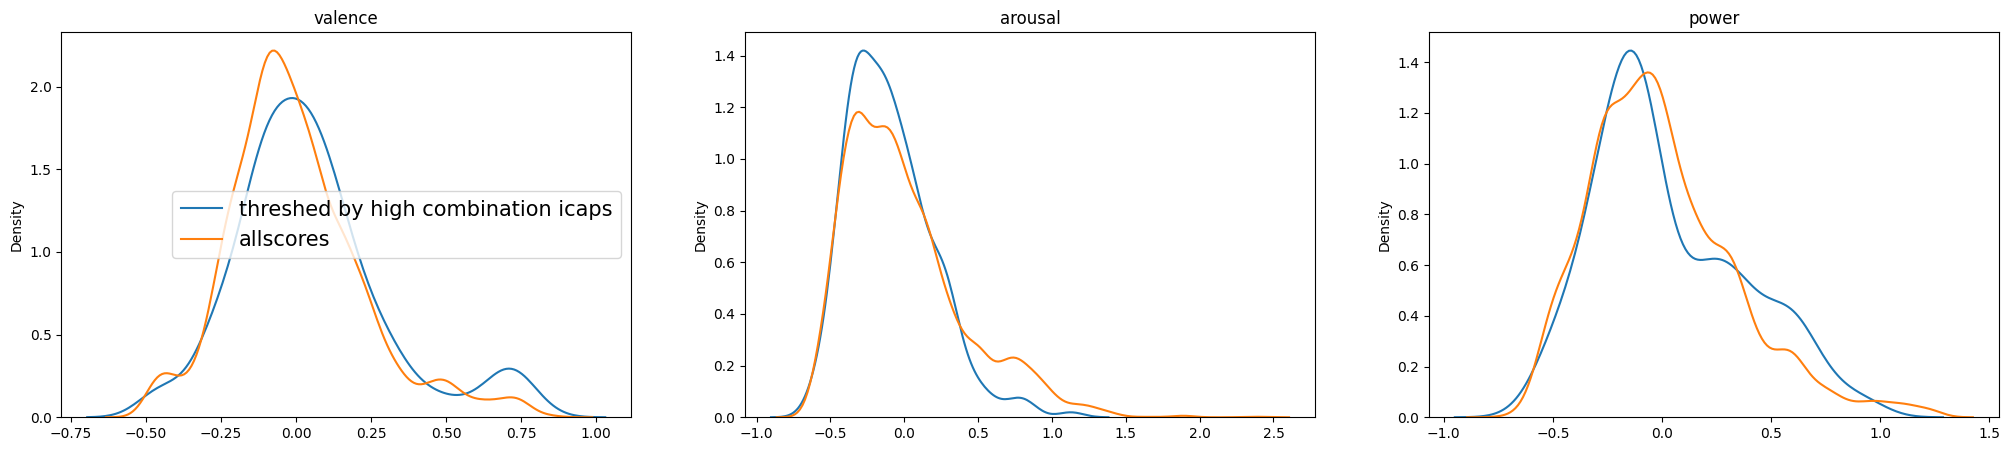

In [259]:
fig,ax = plt.subplots(1,3, figsize=(25,5))

for i in range(3):
    sns.kdeplot(highthresh_fa3[i], ax=ax[i], label='threshed by high combination icaps'.format(labels[i]))
    sns.kdeplot(fa3[i], ax=ax[i], label='allscores'.format(labels[i]))
    ax[i].set_title(labels[i])
    
ax[0].legend(prop={'size':15})

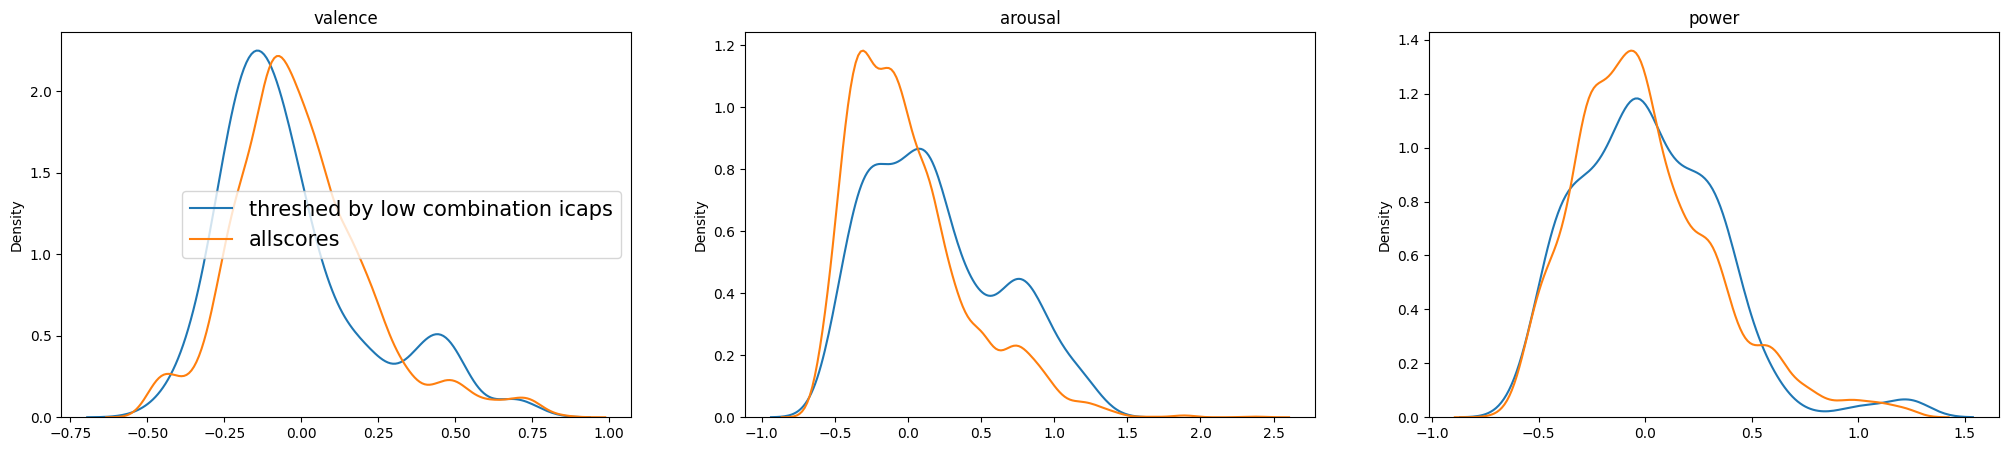

In [261]:
fig,ax = plt.subplots(1,3, figsize=(25,5))

for i in range(3):
    sns.kdeplot(lowthresh_fa3[i], ax=ax[i], label='threshed by low combination icaps'.format(labels[i]))
    sns.kdeplot(fa3[i], ax=ax[i], label='allscores'.format(labels[i]))
    ax[i].set_title(labels[i])
    
ax[0].legend(prop={'size':15})

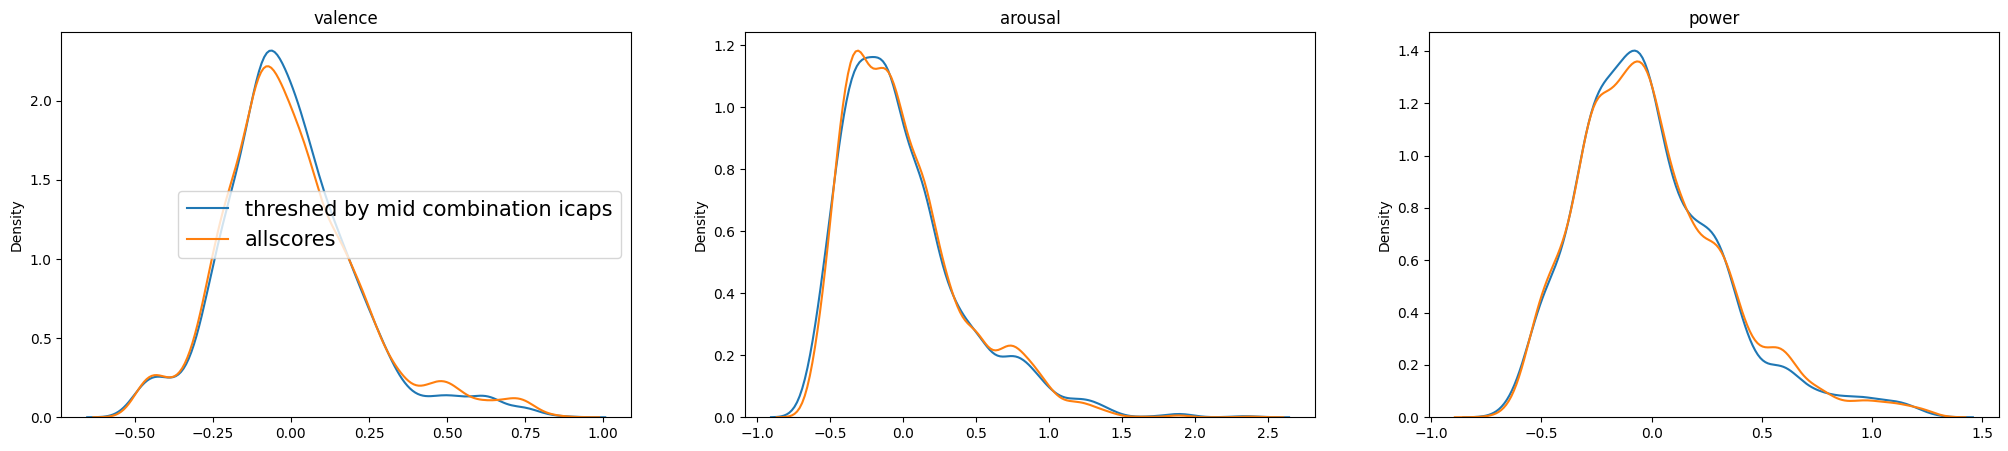

In [262]:
fig,ax = plt.subplots(1,3, figsize=(25,5))

for i in range(3):
    sns.kdeplot(midthresh_fa3[i], ax=ax[i], label='threshed by mid combination icaps'.format(labels[i]))
    sns.kdeplot(fa3[i], ax=ax[i], label='allscores'.format(labels[i]))
    ax[i].set_title(labels[i])
    
ax[0].legend(prop={'size':15})